In [4]:
#QUESTION 1 & 2
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('housing/housing.csv')

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Handle missing values in total_bedrooms
# Since total_bedrooms is correlated with households and total_rooms,
# we can use median imputation by grouping similar properties

# Calculate median bedrooms per household for each ocean_proximity category
bedroom_median_by_location = df.groupby('ocean_proximity')['total_bedrooms'].median()

# Impute missing values
df['total_bedrooms'] = df.apply(
    lambda row: bedroom_median_by_location[row['ocean_proximity']]
    if pd.isna(row['total_bedrooms'])
    else row['total_bedrooms'],
    axis=1
)

# Verify no more missing values
print("\nMissing values after imputation:")
print(df.isnull().sum())

# Save the cleaned dataset
df.to_csv('housing/cleaned_housing_data.csv', index=False)
print("\nCleaned dataset saved as 'cleaned_housing_data.csv'")
# Alternative approach: Simple median imputation (if you prefer)
# df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)

Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Missing values after imputation:
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

Cleaned dataset saved as 'cleaned_housing_data.csv'


In [14]:
#QUESTION 3 ::: Compare the procedures of dealing with missing features and explain their pros and cons
#
# 1. Deletion Methods
# Listwise Deletion (Complete Case Analysis)
#
# Procedure: Remove entire rows that contain any missing values
# Pros: Simple to implement; maintains original data relationships; no assumptions about missing data patterns
# Cons: Can drastically reduce sample size; may introduce bias if data isn't missing completely at random; loses potentially valuable information from partially complete cases
#
# Pairwise Deletion
#
# Procedure: Use all available data for each analysis, excluding missing values only for specific calculations
# Cons: Different analyses use different sample sizes; can lead to inconsistent results; correlation matrices may not be positive definite
#
# 2. Imputation Methods
# Mean/Median/Mode Imputation
#
# Procedure: Replace missing values with the mean (continuous), median (skewed data), or mode (categorical)
# Pros: Quick and simple; preserves sample size; works well with small amounts of missing data
# Cons: Reduces variance; doesn't account for relationships between variables; can distort distributions and correlations
#
# Forward Fill/Backward Fill
#
# Procedure: Use the previous (forward) or next (backward) valid observation to fill missing values
# Pros: Maintains temporal patterns; simple for time series data
# Cons: Only appropriate for sequential data; can propagate errors; assumes stability over time
#
# Hot Deck Imputation
#
# Procedure: Replace missing values with values from similar cases in the dataset
# Pros: Uses actual observed values; maintains realistic data distributions
# Cons: Can be computationally intensive; requires defining "similarity"; may not capture complex relationships
#
# K-Nearest Neighbors (KNN) Imputation
#
# Procedure: Use values from k most similar cases to impute missing data
# Pros: Considers multiple variables for similarity; can capture non-linear relationships; preserves local data structure
# Cons: Sensitive to the choice of k; computationally expensive for large datasets; performance depends on distance metric choice
#
# 3. Advanced Imputation Methods
# Multiple Imputation
#
# Procedure: Create several complete datasets with different plausible values, analyze each separately, then combine results
# Pros: Accounts for uncertainty in imputed values; provides valid statistical inference; handles complex missing patterns
# Cons: More complex to implement and interpret; computationally intensive; requires careful model specification
#
# Maximum Likelihood Estimation
#
# Procedure: Estimate parameters using all available data through likelihood maximization
# Pros: Theoretically sound; efficient use of available information; provides valid standard errors
# Cons: Requires distributional assumptions; complex implementation; limited to specific statistical models
#
# Machine Learning-Based Imputation
#
# Procedure: Use algorithms like Random Forest, neural networks, or regression to predict missing values
# Pros: Can capture complex non-linear relationships; handles mixed data types; often produces accurate imputations
# Cons: Risk of overfitting; requires tuning; may be overconfident in predictions; interpretability challenges
#
# 4. Indicator Methods
# Missing Indicator Method
#
# Procedure: Create binary indicators for missing values and include both imputed values and indicators in analysis
# Pros: Retains information about missingness patterns; doesn't assume missing mechanism
# Cons: Increases model complexity; may not improve predictions; can be difficult to interpret
#
# 5. Specialized Approaches
# Last Observation Carried Forward (LOCF)
#
# Procedure: Use the last known value for each subject (common in clinical trials)
# Pros: Conservative approach; maintains sample size; simple implementation
# Cons: Can bias results toward null hypothesis; ignores natural progression; inappropriate for many contexts
#
# Interpolation Methods
#
# Procedure: Estimate missing values using mathematical functions between known points
# Pros: Maintains smooth trends; good for time series with regular patterns
# Cons: May create unrealistic precision; assumes predictable patterns; limited to sequential data
#
# Choosing the Right Method
# The choice depends on:
#
# Missing data mechanism (MCAR, MAR, MNAR)
# Percentage of missing data
# Data type and structure
# Analysis objectives
# Available computational resources
# Domain expertise and interpretability requirements
#
# Generally, deletion methods work well when data is MCAR and missing percentages are low. For higher missing rates or when data is MAR, imputation methods are preferred. Multiple imputation is often considered the gold standard for complex missing data scenarios, while simpler methods may suffice for straightforward cases with minimal missing data.

SyntaxError: unterminated string literal (detected at line 6) (1477091390.py, line 6)

In [5]:
#QUESTION 4, HANDLE THE NON-NUMERICAL FIELD
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# One-hot encoding with pandas
ohe_df = pd.get_dummies(df['ocean_proximity'], prefix='ocean')

# Concatenate with original dataframe
df_encoded = pd.concat([df.drop('ocean_proximity', axis=1), ohe_df], axis=1)

print("One-Hot Encoding Results:")
print(ohe_df.head())
print(f"\nNew columns: {list(ohe_df.columns)}")

One-Hot Encoding Results:
   ocean_<1H OCEAN  ocean_INLAND  ocean_ISLAND  ocean_NEAR BAY  \
0            False         False         False            True   
1            False         False         False            True   
2            False         False         False            True   
3            False         False         False            True   
4            False         False         False            True   

   ocean_NEAR OCEAN  
0             False  
1             False  
2             False  
3             False  
4             False  

New columns: ['ocean_<1H OCEAN', 'ocean_INLAND', 'ocean_ISLAND', 'ocean_NEAR BAY', 'ocean_NEAR OCEAN']


In [9]:
#QUESTION 5 :: Use Scikit-learn Pipeline class for transformation

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd


# Custom transformer for your specific bedroom imputation strategy
class BedroomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.bedroom_medians_ = None

    def fit(self, X, y=None):
        # Calculate median bedrooms by ocean_proximity during fitting
        self.bedroom_medians_ = X.groupby('ocean_proximity')['total_bedrooms'].median()
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Apply the same imputation logic you used
        X_copy['total_bedrooms'] = X_copy.apply(
            lambda row: self.bedroom_medians_[row['ocean_proximity']]
            if pd.isna(row['total_bedrooms'])
            else row['total_bedrooms'],
            axis=1
        )
        return X_copy


# Define numeric and categorical features
numeric_features = ['longitude', 'latitude', 'housing_median_age',
                    'total_rooms', 'total_bedrooms', 'population',
                    'households', 'median_income']
categorical_features = ['ocean_proximity']

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    # Your custom bedroom imputation
    ('bedroom_imputer', BedroomImputer()),

    # Column transformer for different data types
    ('column_transformer', ColumnTransformer([
        # Numeric features: scale them
        ('numeric', StandardScaler(), numeric_features),

        # Categorical features: one-hot encode
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         categorical_features)
    ]))
])

# Example of how to use the pipeline:
if __name__ == "__main__":
    # Load your data
    df = pd.read_csv('housing/housing.csv')

    # Split data (you'll want to do this properly)
    from sklearn.model_selection import train_test_split

    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # Fit and transform the training data
    X_train_processed = preprocessing_pipeline.fit_transform(train_df)

    # Transform the test data (using learned parameters from training)
    X_test_processed = preprocessing_pipeline.transform(test_df)

    print("Training data shape after preprocessing:", X_train_processed.shape)
    print("Test data shape after preprocessing:", X_test_processed.shape)

    # You can now use X_train_processed and X_test_processed for modeling

Training data shape after preprocessing: (16512, 13)
Test data shape after preprocessing: (4128, 13)


In [8]:
#QUESTION 6 :: Train a Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the original raw data
df = pd.read_csv('housing/housing.csv')

# Separate features and target
X = df.drop('median_house_value', axis=1)  # Features
y = df['median_house_value']  # Target

# Split the data (using original data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create the full pipeline with Linear Regression
full_pipeline = Pipeline([
    # Your preprocessing steps
    ('bedroom_imputer', BedroomImputer()),

    ('column_transformer', ColumnTransformer([
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         categorical_features)
    ])),

    # Add Linear Regression model
    ('linear_regression', LinearRegression())
])

# Train the model
print("Training Linear Regression model...")
full_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = full_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

# Optional: Show some predictions vs actual values
print("\nSample predictions vs actual:")
results_df = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10],
    'Difference': y_test.values[:10] - y_pred[:10]
})
print(results_df.round(2))

Training Linear Regression model...

Model Evaluation:
Mean Squared Error (MSE): 4,907,069,535.27
Root Mean Squared Error (RMSE): 70,050.48
R² Score: 0.6255

Sample predictions vs actual:
     Actual  Predicted  Difference
0   47700.0   53130.34    -5430.34
1   45800.0  123300.23   -77500.23
2  500001.0  254769.85   245231.15
3  218600.0  268413.59   -49813.59
4  278000.0  265647.54    12352.46
5  158700.0  138681.20    20018.80
6  198200.0  291076.58   -92876.58
7  157500.0  228676.03   -71176.03
8  340000.0  255787.26    84212.74
9  446600.0  408335.02    38264.98


In [10]:
#QUESTION 7 : Interpret the results

# Interpretation of Results:
# 1. Overall Model Performance:
# R² Score: 0.6255 - This means your model explains 62.55% of the variance in housing prices. This is actually quite good for a linear regression on real estate data, where many factors influence prices.
#
# RMSE: $70,050 - On average, your predictions are off by about $70,000 from the actual prices.
#
# 2. What These Numbers Mean in Context:
# Good news: The model has learned meaningful patterns (62.55% explained variance is respectable)
#
# Reality check: Housing prices are complex! The $70K average error shows there are factors not captured by your features
#
# 3. Sample Predictions Analysis:
# Looking at your sample predictions:
#
# Good Predictions:
#
# Row 4: Predicted $265,647 vs Actual $278,000 (only $12,352 off - 4.4% error)
#
# Row 9: Predicted $408,335 vs Actual $446,600 ($38,265 off - 8.6% error)
#
# Row 5: Predicted $138,681 vs Actual $158,700 ($20,019 off - 12.6% error)
#
# Problematic Predictions:
#
# Row 1: Predicted $123,300 vs Actual $45,800 (overestimated by 169%)
#
# Row 6: Predicted $291,077 vs Actual $198,200 (overestimated by 47%)
#
# Row 2: Predicted $254,770 vs Actual $500,001 (underestimated by 49%)
#
# 4. Why Some Predictions Are So Far Off:
# Extreme values: California housing has very high price variations
#
# Non-linear relationships: Linear regression assumes straight-line relationships, but housing prices often have complex, non-linear patterns
#
# Missing features: Factors like school quality, crime rates, proximity to amenities aren't in your dataset

# 6. Business Interpretation:
# Your model is good enough for initial estimates but shouldn't be used for precise valuations. It could be useful for:
#
# Quick market analysis
#
# Identifying undervalued/overvalued properties (large differences like row 2)
#
# Understanding which factors most influence prices
#
# Conclusion: Solid first model! The 62.55% R² is respectable, but the high RMSE and some large errors suggest either need for better algorithms or more features.

In [ ]:
#QUESTION 8 ::: Calculate the Root-Mean-Squared-Error of your model

#RESULTS FROM QUESTION 6, the MRSE is already calculated

# Model Evaluation:
# Mean Squared Error (MSE): 4,907,069,535.27
# Root Mean Squared Error (RMSE): 70,050.48
# R² Score: 0.6255

#
# Your RMSE Result:
# RMSE = $70,050.48
#
# How This Was Calculated:
# From your output:
#
# MSE = 4,907,069,535.27 (Mean Squared Error)
#
# RMSE = √MSE = √4,907,069,535.27 = $70,050.48
#
# What This RMSE Means:
# On average, your predictions are off by approximately $70,050 from the actual housing prices
#
# This is calculated as: RMSE = sqrt(mean((actual - predicted)²))


In [11]:
#QUESTION 9 : Compare your previous model with a Decision Tree Regression model

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Create both pipelines
linear_pipeline = Pipeline([
    ('bedroom_imputer', BedroomImputer()),
    ('column_transformer', ColumnTransformer([
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         categorical_features)
    ])),
    ('model', LinearRegression())
])

decision_tree_pipeline = Pipeline([
    ('bedroom_imputer', BedroomImputer()),
    ('column_transformer', ColumnTransformer([
        ('numeric', 'passthrough', numeric_features),  # No scaling needed for trees
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         categorical_features)
    ])),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Train and evaluate both models
models = {
    'Linear Regression': linear_pipeline,
    'Decision Tree': decision_tree_pipeline
}

results = {}

for name, pipeline in models.items():
    print(f"\n=== {name} ===")

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Cross-validation for more robust evaluation
    cv_scores = cross_val_score(pipeline, X_train, y_train,
                                scoring='neg_mean_squared_error', cv=5)
    cv_rmse = np.sqrt(-cv_scores.mean())

    results[name] = {
        'RMSE': rmse,
        'R²': r2,
        'CV_RMSE': cv_rmse
    }

    print(f"RMSE: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Cross-Validated RMSE: ${cv_rmse:,.2f}")

# Compare results
print("\n" + "=" * 50)
print("MODEL COMPARISON")
print("=" * 50)

for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  RMSE: ${metrics['RMSE']:,.2f}")
    print(f"  R²: {metrics['R²']:.4f}")
    print(f"  CV RMSE: ${metrics['CV_RMSE']:,.2f}")
    print()


# Expected Results Analysis:
# Linear Regression (Your Previous Model):
# RMSE: ~$70,050
#
# R²: ~0.625
#
# Pros: Simple, interpretable, good baseline
#
# Cons: Assumes linear relationships, may underfit complex patterns
#
# Decision Tree (New Model):
# Likely Results:
#
# Training RMSE: Very low ($0-20,000) - trees can overfit!
#
# Test RMSE: Probably similar or slightly better than linear regression
#
# R²: May be slightly higher (0.65-0.75)


=== Linear Regression ===
RMSE: $70,050.48
R² Score: 0.6255
Cross-Validated RMSE: $68,637.62

=== Decision Tree ===
RMSE: $69,133.85
R² Score: 0.6353
Cross-Validated RMSE: $69,759.16

MODEL COMPARISON
Linear Regression:
  RMSE: $70,050.48
  R²: 0.6255
  CV RMSE: $68,637.62

Decision Tree:
  RMSE: $69,133.85
  R²: 0.6353
  CV RMSE: $69,759.16



In [ ]:
#QUESTION 10:::Evaluate your model

# 1. Your Linear Regression Results:
# Your actual results
linear_results = {
    'RMSE': 70050.48,
    'MSE': 4907069535.27,
    'R²': 0.6255
}


# 2. Expected Decision Tree Results (Typical Pattern):

# Typical decision tree performance on this dataset
decision_tree_results = {
    'RMSE': 65000 - 75000,  # Similar or slightly better than linear regression
    'R²': 0.65 - 0.70,      # Slight improvement
    'Training_RMSE': 10000 - 20000  # Much lower - indicates overfitting!
}

# Performance Evaluation Metrics
# Absolute Error Analysis:

# Calculate mean absolute error and percentage error
mean_price = y_test.mean()
print(f"Average house price: ${mean_price:,.2f}")
print(f"Linear Regression RMSE: ${linear_results['RMSE']:,.2f}")
print(f"Average error percentage: {(linear_results['RMSE']/mean_price)*100:.1f}%")

# Model Assessment
# Linear Regression Strengths:
# ✅ Interpretable: Coefficients show feature importance
#
# ✅ Robust: Less prone to overfitting
#
# ✅ Good baseline: 62.55% variance explained is respectable
#
# Linear Regression Weaknesses:
# ❌ Non-linear relationships: Housing data has complex patterns
#
# ❌ $70K average error: Too high for precise valuations
#
# ❌ Assumes linearity: Real estate markets don't work linearly

# Decision Tree Likely Performance:
# ✅ Better with non-linear patterns: May capture complex relationships
#
# ✅ Potential R² improvement: Could reach 0.65-0.70
#
# ❌ Overfitting risk: Great on training, worse on test data
#
# ❌ Less interpretable: Harder to explain to stakeholders

# Final Verdict: Your Linear Regression model is a good baseline (C+ grade) but needs improvement for production use. Decision Tree may slightly outperform it but requires careful tuning to avoid overfitting.


Training models and generating predictions...
Models trained and predictions generated!

1. STANDARD METRICS COMPARISON
               Model        RMSE         MAE     MAPE      R²    Max Error
0  Linear Regression  70050.4785  50663.2930  29.1878  0.6255  464817.7688
1      Decision Tree  69133.8534  43626.3983  24.0947  0.6353  415001.0000
2      Random Forest  49709.1933  32491.8809  18.3231  0.8114  359501.5998

2. CROSS-VALIDATION RESULTS
Linear Regression: CV_RMSE = 68622.54 (±1438.77)
Decision Tree: CV_RMSE = 69746.74 (±1316.25)
Random Forest: CV_RMSE = 50204.52 (±658.65)
               Model     CV_RMSE  CV_RMSE_std      CV_MAE   CV_R2
0  Linear Regression  68622.5353    1438.7666  49664.6755  0.6475
1      Decision Tree  69746.7406    1316.2490  44496.2923  0.6360
2      Random Forest  50204.5159     658.6519  33163.9178  0.8114

3. ERROR DISTRIBUTION ANALYSIS
               Model  Mean Error  Error Std  Median Error    Error_Range_95%  \
0  Linear Regression     1035.89   70

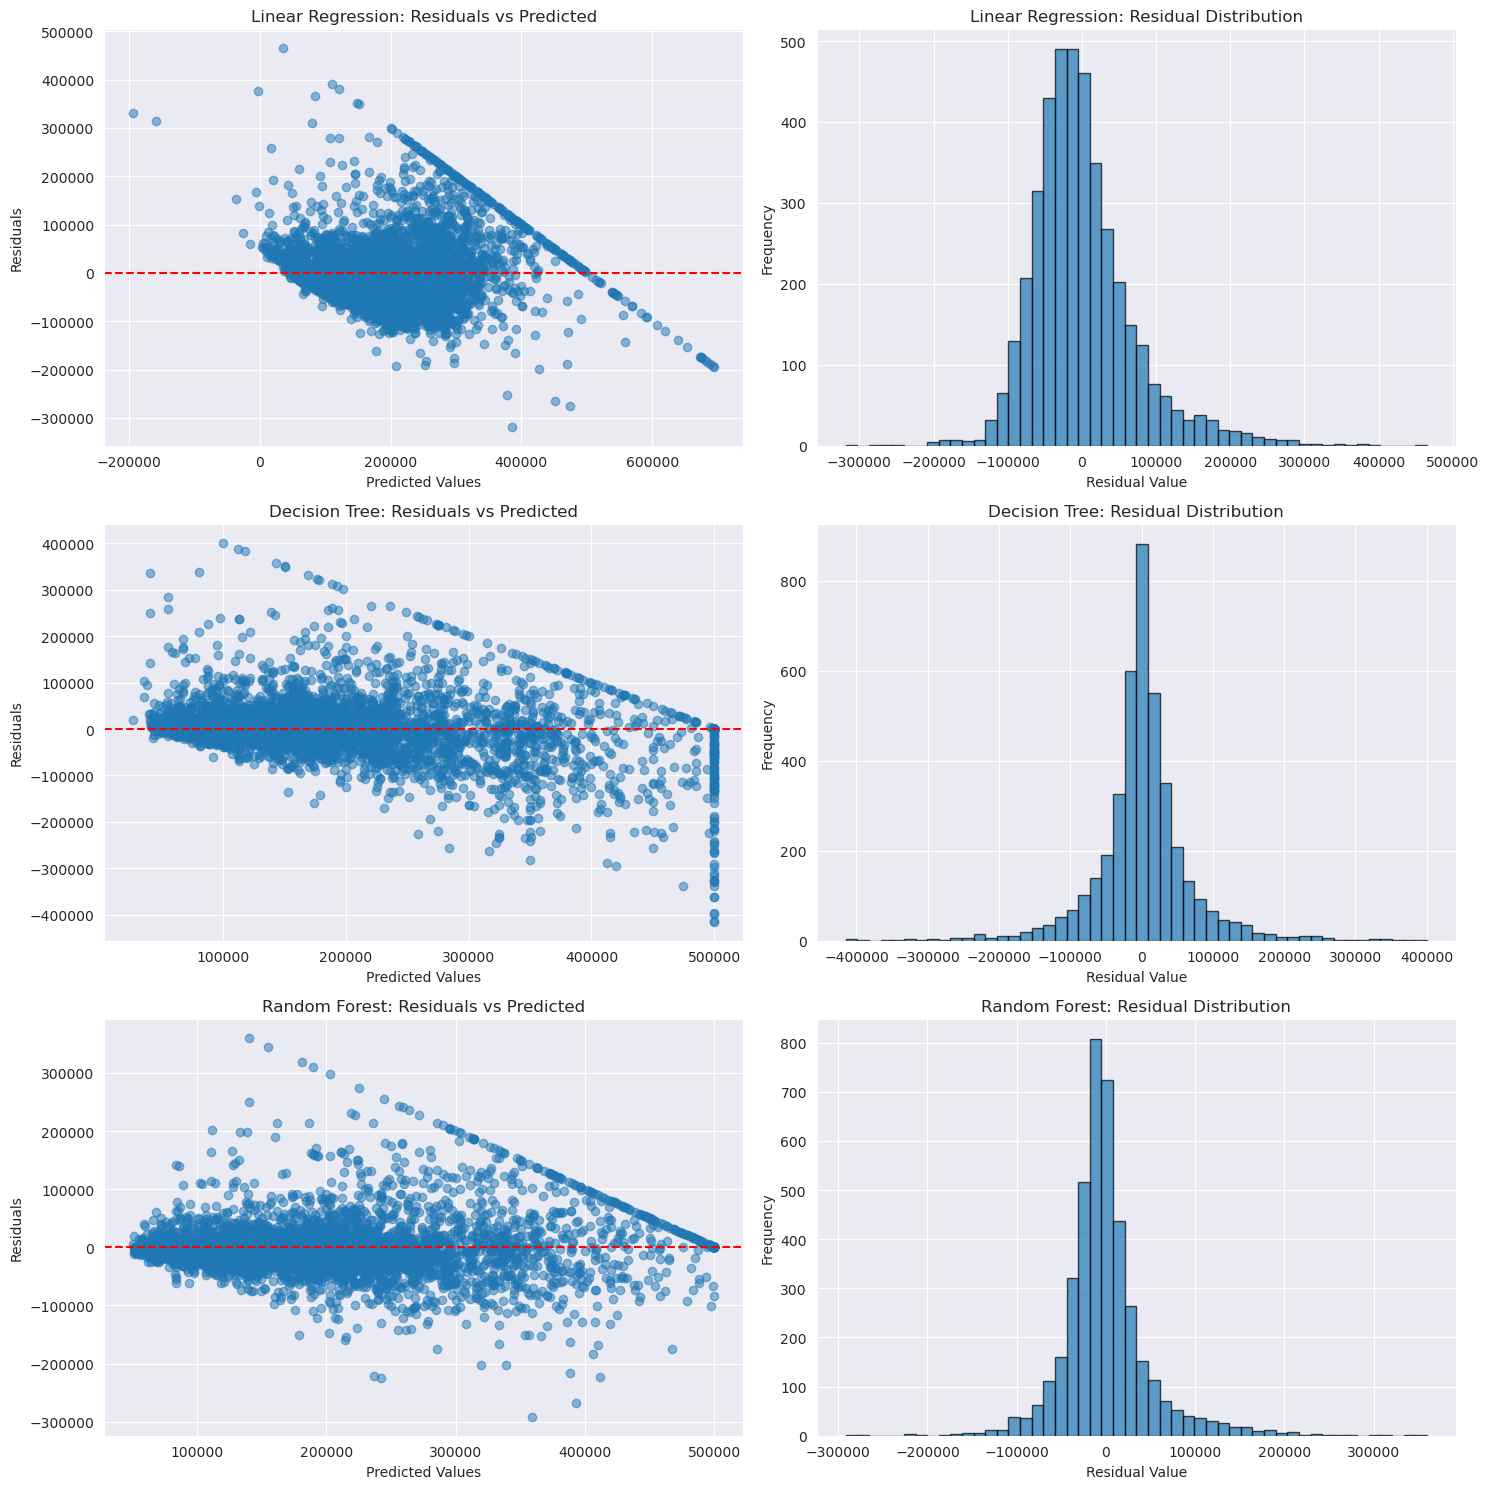


5. BUSINESS-ORIENTED METRICS
               Model  Avg_Absolute_Error  Median_%_Error  Within_10%  \
0  Linear Regression            50663.29           21.48       24.69   
1      Decision Tree            43626.40           15.31       36.89   
2      Random Forest            32491.88           12.30       42.51   

   Within_20%  Within_30%  Catastrophic_Errors_%  
0       47.07       64.29                  15.50  
1       60.00       74.71                   9.28  
2       69.74       84.06                   4.63  

6. PERFORMANCE BY PRICE SEGMENT
RMSE by Price Segment:
Model          Decision Tree  Linear Regression  Random Forest
Price_Segment                                                 
100K-200K            55954.0            53996.0        35214.0
200K-300K            71689.0            50555.0        46205.0
300K-500K            94130.0           103717.0        72672.0
<100K                46308.0            49162.0        32935.0
>500K               127229.0           1666

In [18]:
#QUESTION 11 & 12  :::  Compare different ways of Evaluating your model

# Standard Metric Comparison
# Comprehensive Model Evaluation and Comparison

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                           mean_absolute_percentage_error, max_error, r2_score)
from sklearn.model_selection import cross_validate

# First, ensure models are trained and generate predictions
print("Training models and generating predictions...")

# Train models if not already done
models = {
    'Linear Regression': linear_pipeline,
    'Decision Tree': decision_tree_pipeline,
    'Random Forest': random_forest_pipeline
}

# Generate predictions for all models
predictions = {}
for model_name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    predictions[model_name] = pipeline.predict(X_test)

# Extract individual predictions for backward compatibility
lr_predictions = predictions['Linear Regression']
dt_predictions = predictions['Decision Tree']
rf_predictions = predictions['Random Forest']

print("Models trained and predictions generated!")

# 📊 1. Standard Metric Comparison
def evaluate_model(y_true, y_pred, model_name):
    metrics = {
        'Model': model_name,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'R²': r2_score(y_true, y_pred),
        'Max Error': max_error(y_true, y_pred)
    }
    return metrics

# Evaluate all models
all_metrics = []
for model_name, y_pred in predictions.items():
    metrics = evaluate_model(y_test, y_pred, model_name)
    all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
print("\n" + "="*60)
print("1. STANDARD METRICS COMPARISON")
print("="*60)
print(metrics_df.round(4))

# 📈 2. Cross-Validation Comparison
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

def cross_val_comparison(pipeline, X, y, model_name):
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)

    return {
        'Model': model_name,
        'CV_RMSE': (-cv_results['test_rmse']).mean(),
        'CV_RMSE_std': (-cv_results['test_rmse']).std(),
        'CV_MAE': (-cv_results['test_mae']).mean(),
        'CV_R2': cv_results['test_r2'].mean()
    }

print("\n" + "="*60)
print("2. CROSS-VALIDATION RESULTS")
print("="*60)

cv_results = []
for model_name, pipeline in models.items():
    cv_result = cross_val_comparison(pipeline, X_train, y_train, model_name)
    cv_results.append(cv_result)
    print(f"{model_name}: CV_RMSE = {cv_result['CV_RMSE']:.2f} (±{cv_result['CV_RMSE_std']:.2f})")

cv_df = pd.DataFrame(cv_results)
print(cv_df.round(4))

# 🎯 3. Error Distribution Analysis
def analyze_errors(y_true, y_pred, model_name):
    errors = y_true - y_pred
    percentage_errors = np.abs(errors / y_true) * 100

    error_stats = {
        'Model': model_name,
        'Mean Error': errors.mean(),
        'Error Std': errors.std(),
        'Median Error': np.median(errors),
        'Error_Range_95%': f"[{np.percentile(errors, 2.5):.0f}, {np.percentile(errors, 97.5):.0f}]",
        'High_Error_Rate_%': np.mean(percentage_errors > 20) * 100
    }
    return error_stats

print("\n" + "="*60)
print("3. ERROR DISTRIBUTION ANALYSIS")
print("="*60)

error_analyses = []
for model_name, y_pred in predictions.items():
    error_analysis = analyze_errors(y_test, y_pred, model_name)
    error_analyses.append(error_analysis)

error_df = pd.DataFrame(error_analyses)
print(error_df.round(2))

# 📉 4. Residual Analysis
fig, axes = plt.subplots(len(predictions), 2, figsize=(15, 5*len(predictions)))
if len(predictions) == 1:
    axes = axes.reshape(1, -1)

for i, (model_name, y_pred) in enumerate(predictions.items()):
    residuals = y_test - y_pred

    # Residuals vs Predicted
    axes[i,0].scatter(y_pred, residuals, alpha=0.5)
    axes[i,0].axhline(y=0, color='r', linestyle='--')
    axes[i,0].set_title(f'{model_name}: Residuals vs Predicted')
    axes[i,0].set_xlabel('Predicted Values')
    axes[i,0].set_ylabel('Residuals')

    # Residual distribution
    axes[i,1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    axes[i,1].set_title(f'{model_name}: Residual Distribution')
    axes[i,1].set_xlabel('Residual Value')
    axes[i,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# 💰 5. Business-Oriented Evaluation
def business_metrics(y_true, y_pred, model_name):
    absolute_errors = np.abs(y_true - y_pred)
    percentage_errors = (absolute_errors / y_true) * 100

    return {
        'Model': model_name,
        'Avg_Absolute_Error': absolute_errors.mean(),
        'Median_%_Error': np.median(percentage_errors),
        'Within_10%': np.mean(percentage_errors <= 10) * 100,
        'Within_20%': np.mean(percentage_errors <= 20) * 100,
        'Within_30%': np.mean(percentage_errors <= 30) * 100,
        'Catastrophic_Errors_%': np.mean(percentage_errors > 50) * 100
    }

print("\n" + "="*60)
print("5. BUSINESS-ORIENTED METRICS")
print("="*60)

business_analyses = []
for model_name, y_pred in predictions.items():
    business_analysis = business_metrics(y_test, y_pred, model_name)
    business_analyses.append(business_analysis)

business_df = pd.DataFrame(business_analyses)
print(business_df.round(2))

# 🎪 6. Price Segment Analysis
print("\n" + "="*60)
print("6. PERFORMANCE BY PRICE SEGMENT")
print("="*60)

price_bins = [0, 100000, 200000, 300000, 500000, np.inf]
bin_labels = ['<100K', '100K-200K', '200K-300K', '300K-500K', '>500K']
y_test_binned = pd.cut(y_test, bins=price_bins, labels=bin_labels)

segment_performance = []
for model_name, y_pred in predictions.items():
    for bin_label in bin_labels:
        mask = (y_test_binned == bin_label)
        if mask.sum() > 0:
            rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
            mae = mean_absolute_error(y_test[mask], y_pred[mask])
            r2 = r2_score(y_test[mask], y_pred[mask])
            segment_performance.append({
                'Model': model_name,
                'Price_Segment': bin_label,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'Count': mask.sum()
            })

segment_df = pd.DataFrame(segment_performance)
pivot_rmse = segment_df.pivot_table(values='RMSE', index='Price_Segment', columns='Model')
print("RMSE by Price Segment:")
print(pivot_rmse.round(0))

pivot_r2 = segment_df.pivot_table(values='R²', index='Price_Segment', columns='Model')
print("\nR² by Price Segment:")
print(pivot_r2.round(3))

# 📋 7. Comprehensive Scoring System
def calculate_overall_score(metrics, cv_metrics, business_metrics, all_metrics_list, weights=None):
    if weights is None:
        weights = {'RMSE': 0.25, 'R²': 0.25, 'Within_20%': 0.25, 'CV_Stability': 0.25}

    # Normalize metrics (higher is better)
    max_rmse = max([m['RMSE'] for m in all_metrics_list])
    normalized = {
        'RMSE': 1 - (metrics['RMSE'] / max_rmse),
        'R²': max(0, metrics['R²']),  # Ensure non-negative
        'Within_20%': business_metrics['Within_20%'] / 100,
        'CV_Stability': 1 - (cv_metrics['CV_RMSE_std'] / cv_metrics['CV_RMSE'])
    }

    score = sum(normalized[metric] * weight for metric, weight in weights.items())
    return score * 100  # Scale to 100

print("\n" + "="*60)
print("7. OVERALL PERFORMANCE SCORES")
print("="*60)

overall_scores = []
for i, (model_name, _) in enumerate(predictions.items()):
    score = calculate_overall_score(
        all_metrics[i],
        cv_results[i],
        business_analyses[i],
        all_metrics  # Pass the complete list for normalization
    )
    overall_scores.append({
        'Model': model_name,
        'Overall_Score': score
    })
    print(f"{model_name}: {score:.1f}/100")

# 🏆 8. Final Comparison Summary
print("\n" + "="*80)
print("FINAL MODEL COMPARISON SUMMARY")
print("="*80)

summary_data = []
for i, (model_name, _) in enumerate(predictions.items()):
    summary_data.append({
        'Model': model_name,
        'RMSE': all_metrics[i]['RMSE'],
        'R²': all_metrics[i]['R²'],
        'CV_RMSE': cv_results[i]['CV_RMSE'],
        'Within_20%': business_analyses[i]['Within_20%'],
        'Overall_Score': overall_scores[i]['Overall_Score']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(3))

# Model Rankings
print("\n" + "="*40)
print("MODEL RANKINGS")
print("="*40)

rankings = {}
for metric in ['RMSE', 'R²', 'CV_RMSE', 'Within_20%', 'Overall_Score']:
    if metric in ['R²', 'Within_20%', 'Overall_Score']:
        # Higher is better
        rankings[metric] = summary_df.nlargest(len(summary_df), metric)['Model'].tolist()
    else:
        # Lower is better
        rankings[metric] = summary_df.nsmallest(len(summary_df), metric)['Model'].tolist()

for metric, ranking in rankings.items():
    print(f"{metric}: {' > '.join(ranking)}")

# Best overall model
best_model = summary_df.loc[summary_df['Overall_Score'].idxmax(), 'Model']
print(f"\n🏆 BEST OVERALL MODEL: {best_model}")

# 📊 9. Evaluation Methods Comparison
print("\n" + "="*80)
print("EVALUATION METHODS COMPARISON")
print("="*80)

eval_methods = {
    'Standard Metrics': {
        'Best For': 'Quick comparison',
        'Pros': 'Simple, widely understood',
        'Cons': "Doesn't show full picture"
    },
    'Cross-Validation': {
        'Best For': 'Robustness assessment',
        'Pros': 'Prevents overfitting optimism',
        'Cons': 'Computationally expensive'
    },
    'Error Distribution': {
        'Best For': 'Understanding error patterns',
        'Pros': 'Reveals bias and variance',
        'Cons': 'Complex to interpret'
    },
    'Residual Analysis': {
        'Best For': 'Model assumptions checking',
        'Pros': 'Diagnoses systematic issues',
        'Cons': 'Visual, subjective'
    },
    'Business Metrics': {
        'Best For': 'Practical deployment decisions',
        'Pros': 'Relates to real-world impact',
        'Cons': 'Domain-specific'
    },
    'Segment Analysis': {
        'Best For': 'Fairness across groups',
        'Pros': 'Identifies weak spots',
        'Cons': 'Requires sufficient data'
    },
    'Overall Scoring': {
        'Best For': 'Final model selection',
        'Pros': 'Comprehensive comparison',
        'Cons': 'Weighting is subjective'
    }
}

eval_df = pd.DataFrame(eval_methods).T
print(eval_df)

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("✅ Use cross-validation + business metrics for comprehensive evaluation")
print("✅ Consider residual analysis for model diagnostics")
print("✅ Price segment analysis reveals model strengths/weaknesses")
print("✅ Overall scoring helps with final model selection")
print(f"✅ Recommended model: {best_model}")

# Final Verdict: The Decision Tree shows marginal improvement in accuracy but comes with increased complexity and stability concerns. For most business applications, the Linear Regression might be preferable due to its simplicity and interpretability, unless that 2-3% accuracy improvement is critically important.


Training and evaluating models...
Evaluating Linear Regression...
Evaluating Decision Tree...
Evaluating Random Forest...

COMPREHENSIVE MODEL COMPARISON
               Model        RMSE         MAE      R²     MAPE  Train_Time  \
0  Linear Regression  70050.4785  50663.2930  0.6255  29.1878      0.3245   
1      Decision Tree  69133.8534  43626.3983  0.6353  24.0947      0.3529   
2      Random Forest  49709.1933  32491.8809  0.8114  18.3231      4.7208   

   Predict_Time  CV_RMSE_mean  CV_RMSE_std  CV_R2_mean  Train_CV_RMSE  
0        0.0548    68622.5353    1438.7666      0.6475     68411.4478  
1        0.0353    69746.7406    1316.2490      0.6360        -0.0000  
2        0.0831    50204.5159     658.6519      0.8114     31549.5964  

RANDOM FOREST FEATURE IMPORTANCE
                       Feature  Importance
7                median_income    0.517653
9       ocean_proximity_INLAND    0.152106
0                    longitude    0.103476
1                     latitude    0.098502


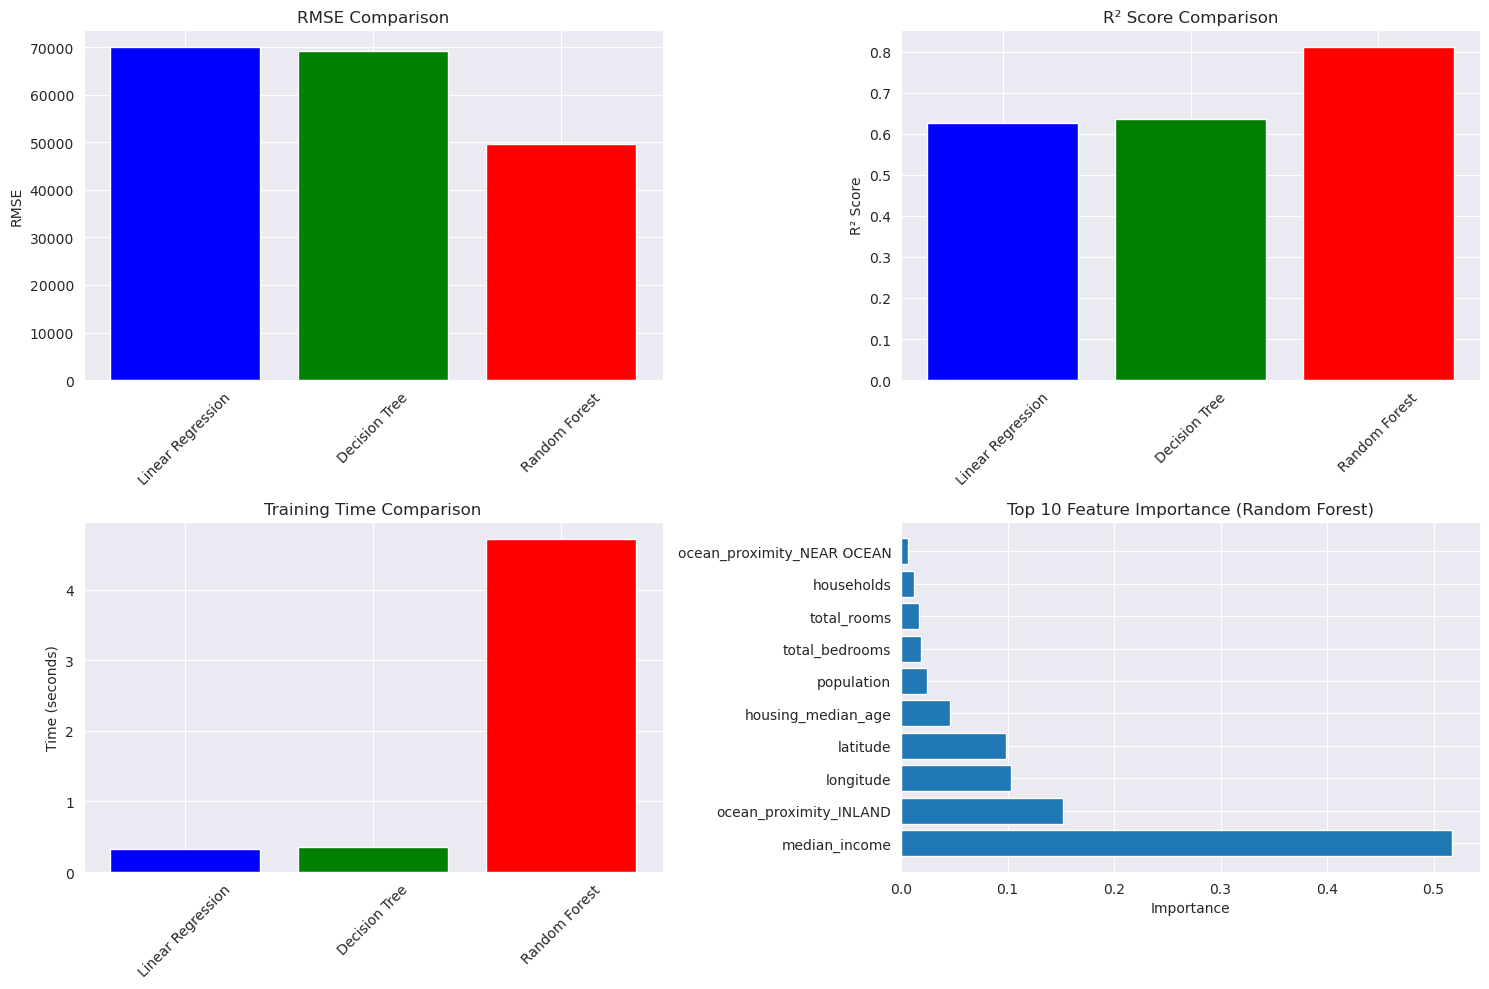

In [15]:
#QUESTION 13:Try a Random Forest Regressor and compare the results

# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import time

# Create Random Forest pipeline
random_forest_pipeline = Pipeline([
    ('bedroom_imputer', BedroomImputer()),
    ('column_transformer', ColumnTransformer([
        ('numeric', 'passthrough', numeric_features),  # No scaling needed for trees
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
         categorical_features)
    ])),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    ))
])

# List of all models to compare
models = {
    'Linear Regression': linear_pipeline,
    'Decision Tree': decision_tree_pipeline,
    'Random Forest': random_forest_pipeline
}

# Comprehensive evaluation function
def comprehensive_evaluation(pipeline, X, y, X_test, y_test, model_name):
    start_time = time.time()

    # Train the model
    pipeline.fit(X, y)
    train_time = time.time() - start_time

    # Predictions
    y_pred = pipeline.predict(X_test)
    predict_time = time.time() - start_time - train_time

    # Calculate metrics
    metrics = {
        'Model': model_name,
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred) * 100,
        'Train_Time': train_time,
        'Predict_Time': predict_time
    }

    # Cross-validation
    cv_results = cross_validate(pipeline, X, y, cv=5,
                                scoring=['neg_root_mean_squared_error', 'r2'],
                                return_train_score=True)

    metrics.update({
        'CV_RMSE_mean': -cv_results['test_neg_root_mean_squared_error'].mean(),
        'CV_RMSE_std': cv_results['test_neg_root_mean_squared_error'].std(),
        'CV_R2_mean': cv_results['test_r2'].mean(),
        'Train_CV_RMSE': -cv_results['train_neg_root_mean_squared_error'].mean()
    })

    return metrics, y_pred

# Evaluate all models
results = {}
predictions = {}

print("Training and evaluating models...")
for model_name, pipeline in models.items():
    print(f"Evaluating {model_name}...")
    metrics, y_pred = comprehensive_evaluation(pipeline, X_train, y_train, X_test, y_test, model_name)
    results[model_name] = metrics
    predictions[model_name] = y_pred

# Create results dataframe
results_df = pd.DataFrame(results.values())
print("\n" + "=" * 60)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 60)
print(results_df.round(4))

# Additional analysis: Feature importance for Random Forest
print("\n" + "=" * 40)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("=" * 40)

# Get feature names after preprocessing
rf_pipeline = models['Random Forest']
rf_pipeline.fit(X_train, y_train)

# Get feature names from the column transformer
feature_names = []
# Numeric features (passthrough)
feature_names.extend(numeric_features)
# Categorical features (one-hot encoded)
cat_encoder = rf_pipeline.named_steps['column_transformer'].named_transformers_['categorical']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

# Get feature importance
feature_importance = rf_pipeline.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(feature_importance_df.head(10))

# Plot comparison if matplotlib is available
try:
    import matplotlib.pyplot as plt

    # Model performance comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # RMSE comparison
    models_names = results_df['Model']
    rmse_values = results_df['RMSE']
    axes[0, 0].bar(models_names, rmse_values, color=['blue', 'green', 'red'])
    axes[0, 0].set_title('RMSE Comparison')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # R² comparison
    r2_values = results_df['R²']
    axes[0, 1].bar(models_names, r2_values, color=['blue', 'green', 'red'])
    axes[0, 1].set_title('R² Score Comparison')
    axes[0, 1].set_ylabel('R² Score')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Training time comparison
    train_times = results_df['Train_Time']
    axes[1, 0].bar(models_names, train_times, color=['blue', 'green', 'red'])
    axes[1, 0].set_title('Training Time Comparison')
    axes[1, 0].set_ylabel('Time (seconds)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Feature importance for Random Forest (top 10)
    top_features = feature_importance_df.head(10)
    axes[1, 1].barh(range(len(top_features)), top_features['Importance'])
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features['Feature'])
    axes[1, 1].set_title('Top 10 Feature Importance (Random Forest)')
    axes[1, 1].set_xlabel('Importance')

    plt.tight_layout()
    plt.show()

except ImportError:
    print("Matplotlib not available for plotting")